# Classifying Names with a Character-Level RNN

## Preparing the Data

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

In [2]:
from livelossplot import PlotLosses

/home/takoroy/datascience/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def findFiles(path):
    return glob.glob(path)

print(findFiles('namedata/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('namedata/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['namedata/names/Portuguese.txt', 'namedata/names/Greek.txt', 'namedata/names/Chinese.txt', 'namedata/names/Dutch.txt', 'namedata/names/Korean.txt', 'namedata/names/Vietnamese.txt', 'namedata/names/Arabic.txt', 'namedata/names/English.txt', 'namedata/names/French.txt', 'namedata/names/Spanish.txt', 'namedata/names/German.txt', 'namedata/names/Czech.txt', 'namedata/names/Japanese.txt', 'namedata/names/Russian.txt', 'namedata/names/Irish.txt', 'namedata/names/Italian.txt', 'namedata/names/Scottish.txt', 'namedata/names/Polish.txt']
Slusarski


In [4]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## Turning Names into Tensors

In [5]:
all_letters  # uniqueな文字

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [6]:
n_letters  # uniqueな文字数

57

In [7]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
torch.Size([5, 1, 57])


## Creating the Network

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [100]:
class BidirectionalGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BidirectionalGRU, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = 1
        self.bigru = nn.GRU(input_size, hidden_size, num_layers=self.num_layers, bidirectional=True)
        self.linear = nn.Linear(hidden_size*2, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        input = input.to(device)
        hidden = torch.zeros(self.num_layers*2, 1, self.hidden_size).to(device)
        output, _ = self.bigru(input, hidden)
        output = output[-1]
        output = self.linear(output)
        output = self.softmax(output)
        return output

    def initHidden(self):
        return torch.zeros(self.num_layers*2, self.hidden_size)

n_hidden = 128
rnn = BidirectionalGRU(n_letters, n_hidden, n_categories)
rnn = rnn.to(device)

In [101]:
input = lineToTensor('A')

output = rnn(input)
output

tensor([[-2.8843, -2.8610, -2.8978, -2.9292, -2.8639, -2.8426, -2.8962,
         -2.8959, -2.9774, -2.8981, -2.7844, -2.8874, -2.9292, -2.8633,
         -2.8479, -2.8701, -2.9497, -2.9676]], device='cuda:0')

In [102]:
input = lineToTensor('Albert')

output = rnn(input)
print(output)

tensor([[-2.8869, -2.8444, -2.9087, -2.9643, -2.9510, -2.7955, -2.8988,
         -2.9285, -2.9966, -2.8885, -2.8021, -2.8194, -2.9531, -2.8856,
         -2.8434, -2.8358, -2.9227, -2.9304]], device='cuda:0')


## Training

### Preparing for Training

In [103]:
# outputのtopkを取得し、その国名とインデックスを出力
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Vietnamese', 5)


In [104]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    """教師データ中の文字列をランダムに取得
    """
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Czech / line = Duyava
category = Arabic / line = Ganem
category = Irish / line = Macshuibhne
category = Scottish / line = Taylor
category = German / line = Bosch
category = Portuguese / line = Pinheiro
category = French / line = Dufort
category = Czech / line = Kopecky
category = Vietnamese / line = Duong
category = Greek / line = Kokoris


### Training the Network

In [105]:
criterion = nn.NLLLoss()

In [111]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    rnn.zero_grad()
    
    output = rnn(line_tensor)
    
    loss = criterion(output, category_tensor.to(device))
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

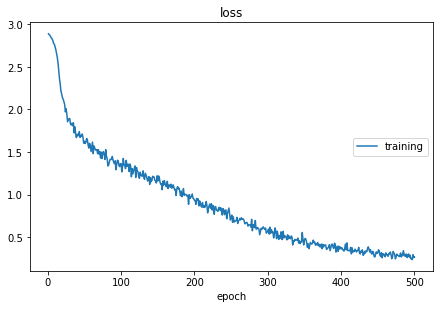

In [112]:
import time
import math

n_iters = 500000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

liveloss = PlotLosses() 

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        
        liveloss.update({
            'loss': current_loss / plot_every
        })
        liveloss.draw()
        
        current_loss = 0

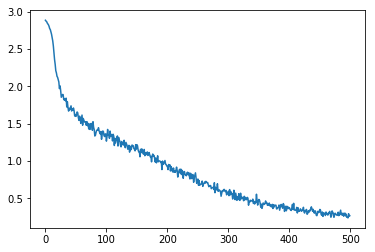

In [113]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.figure()
plt.plot(all_losses)

## Evaluating the Results

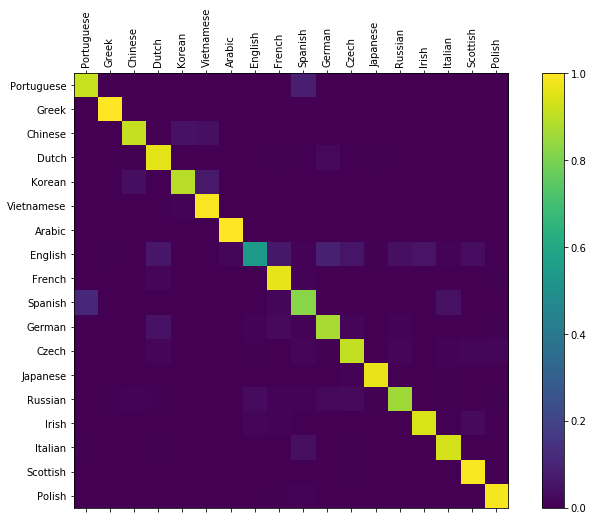

In [115]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    
    output = rnn(line_tensor)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Running on User Input

In [116]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Roy')
predict('Takumi')


> Dovesky
(-0.30) Czech
(-1.35) Russian
(-7.62) English

> Jackson
(-0.02) Scottish
(-3.82) English
(-7.93) Russian

> Satoshi
(-0.02) Japanese
(-4.63) Russian
(-5.11) Arabic

> Roy
(-0.24) French
(-2.17) Korean
(-3.02) English

> Takumi
(-0.02) Japanese
(-3.99) Arabic
(-5.10) Russian
